### Load and inspect bathymetry and ice shelf draft 

ND, April 2025

In [27]:
makeplots=True
writefields=True

In [17]:
##%matplotlib widget
##%load_ext autoreload
##%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import os
from xmitgcm import open_mdsdataset
from xmitgcm.utils import get_grid_from_input, get_extra_metadata
import xgcm
from scipy.interpolate import interp1d
import re
import datetime as dt
import sys
from myutils import *
from MITgcmutils import llc
import xarray as xr
import cmocean.cm as cmo
import cartopy as cart
import ecco_v4_py as ecco
import seaborn as sns
sns.set_context(context='paper', font_scale=1.5)
from scipy.ndimage import gaussian_filter
from scipy.io import loadmat
import mat73
import warnings
warnings.filterwarnings('ignore')

%run losch_plotting_funcs.ipynb
landcolor='lightgrey'

#### Load grid and old bathymetry

This is the bathymetry used in Chapter 5 of the PhD Thesis.

In [3]:
rdir = '/albedo/work/user/ndettlin/MITgcm/verification/global/run/gm_200_taper_sa/'
ds = open_mdsdataset(rdir,prefix=['diags3D'],delta_t=1800,geometry='llc', ignore_unknown_vars=True)

llc270_extra_metadata = get_extra_metadata(domain='llc', nx=270)
grid = get_grid_from_input(os.path.join('/albedo/home/mlosch/MITgcm/MITgcm/llc270/input','tile<NFACET>.mitgrid'),
                           geometry='llc', extra_metadata=llc270_extra_metadata)


# find out the file numbers to read
d00 = open_mdsdataset(rdir,prefix=['3d_diag_z'],delta_t=1800,geometry='llc')
coords = d00.coords.to_dataset().reset_coords()

# important: create grid object before fixing any coordinates
grd = xgcm.Grid(coords, periodic=False, face_connections=face_connections)

coords['XC'] = grid.XC
coords['YC'] = grid.YC
coords['XG'] = grid.XG
coords['YG'] = grid.YG

prefix = list(ds.keys())
ds[prefix] = ds[prefix].where(ds[prefix] != 0)

### some plotting stuff
mapper = LLCMapper(coords)
mapper_2 = LLCMapper_2(coords)
mapper_noland = LLCMapper_noland(coords)


proj_glob=cart.crs.EqualEarth() #central_longitude=180.0-19) #central_longitude=7.0)
proj_antarctic=cart.crs.Stereographic(central_latitude=-87.8, central_longitude=0.0)
proj_arctic=cart.crs.NorthPolarStereo(central_longitude=-30)

msk = ds.maskC[0,...].compute()
rac = (ds.rA*ds.maskC[0,...]).compute()

#### Load bathymetry and ice shelf draft

This is the bathymetry and ice shelf draft following Schaffer et al. 2019.

The dataset has been interpolated onto the LLC270 grid by Dustin Caroll. Supposedly, this dataset is processed in way that avoids awkward situations like for example icedraft > ocean depth. 

In [12]:
### this function reshapes the bin files so that they can be plotted nicely. 
### This is not necessary for using the files as input (shape is the same as using mit.rdmds())

def regrid_carroll(bathy_raw,ds):
    
    bathy = xr.zeros_like(ds.Depth)
    bathy[0:7,:,:] = bathy_raw.reshape([13,270,270])[0:7,:,:]
    
    bathy_rest = bathy_raw[510300:947700].reshape([270,2,3*270])
    bathy_rest_ordered = np.zeros([2*270,3*270])
    bathy_rest_ordered[::2,:] = bathy_rest[:,0,:]
    bathy_rest_ordered[1::2,:] = bathy_rest[:,1,:]
    
    bathy[7,:,:] = bathy_rest_ordered[0:270, 0:270]
    bathy[8,:,:] = bathy_rest_ordered[0:270, 270:540]
    bathy[9,:,:] = bathy_rest_ordered[0:270, 540:810]
    
    bathy[10,:,:] = bathy_rest_ordered[270:540, 0:270]
    bathy[11,:,:] = bathy_rest_ordered[270:540, 270:540]
    bathy[12,:,:] = bathy_rest_ordered[270:540, 540:810]
    
    return bathy


In [13]:
# this is the bathymetry file
bathy_path = '/albedo/home/ndettlin/paper_global_model/bathy_ice/LLC_270_bathy_all_dustin_method.bin'

# this is the ice draft
ice_path = '/albedo/home/ndettlin/paper_global_model/bathy_ice/LLC_270_ice_all_dustin_method.bin'

# this is a merged product 
merged_path = '/albedo/home/ndettlin/paper_global_model/bathy_ice/LLC_270_Schaffer_2019_merged_bathy.mat'

bathy = np.fromfile(bathy_path, dtype='>f4')
bathy = regrid_carroll(bathy, ds)

ice = np.fromfile(ice_path, dtype='>f4')
ice = regrid_carroll(ice, ds)

bathy_merged = mat73.loadmat(merged_path)
bathy_merged = regrid_carroll(bathy_merged['depth'].swapaxes(0,1).reshape([13*270*270]), ds)

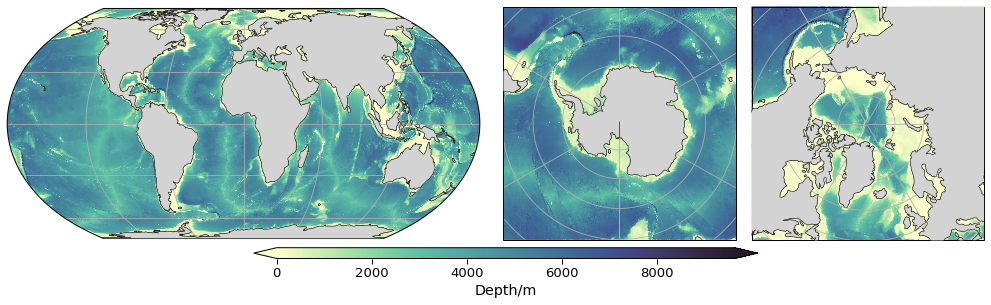

In [102]:
fig = plt.figure(figsize=(14,7.5), layout='tight')

ax1 = fig.add_subplot(1,2,1, projection=proj_glob)
bx, hm0, gl = mapper(bathy, ax=ax1, cmap=cmo.deep)

cax = fig.add_axes([0.26, 0.25, 0.5, 0.02])
cb = fig.colorbar(hm0, ax=cax, cax=cax, extend='both', label='Depth/m',
               orientation='horizontal', shrink=.6)

ax2 = fig.add_subplot(1,4,3, projection=proj_antarctic)

ax2.set_extent([-180, 180, -90, -50], cart.crs.PlateCarree())

bx, hm0, gl = mapper(bathy, ax=ax2, cmap=cmo.deep, vmax=8000)

ax3 = fig.add_subplot(1,4,4, projection=proj_arctic)

ax3.set_extent([-180, 180, 50, 90], cart.crs.PlateCarree())
bx, hm0, gl = mapper(bathy, ax=ax3, cmap=cmo.deep, vmax=8000)

if makeplots:
    plt.savefig('plots/bathy_Schaffer2019_global.jpg', bbox_inches='tight', dpi=300)

#### Closer look at one of the Antarctic tiles

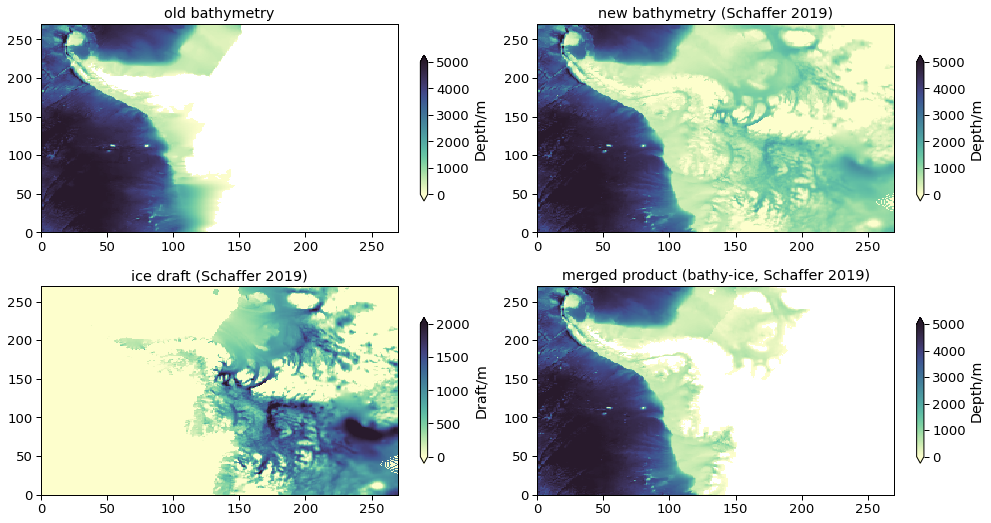

In [103]:
fig = plt.figure(figsize=(14,7.5), layout='tight')

ax1 = fig.add_subplot(2,2,1)
c=ax1.pcolormesh(ds.Depth.isel(face=12).where(ds.Depth.isel(face=12)!=0), cmap=cmo.deep, vmax=5000, vmin=0)
cb = fig.colorbar(c, ax=ax1, extend='both', label='Depth/m', orientation='vertical', shrink=.7)
ax1.set_title('old bathymetry')

ax2 = fig.add_subplot(2,2,2)
c=ax2.pcolormesh(bathy.isel(face=12), cmap=cmo.deep, vmax=5000, vmin=0)
cb = fig.colorbar(c, ax=ax2, extend='both', label='Depth/m', orientation='vertical', shrink=.7)
ax2.set_title('new bathymetry (Schaffer 2019)')

ax3 = fig.add_subplot(2,2,3)
c=ax3.pcolormesh(ice.isel(face=12), cmap=cmo.deep, vmax=2000, vmin=0)
cb = fig.colorbar(c, ax=ax3, extend='both', label='Draft/m', orientation='vertical', shrink=.7)
ax3.set_title('ice draft (Schaffer 2019)')

ax4 = fig.add_subplot(2,2,4)
c=ax4.pcolormesh(-bathy_merged.isel(face=12), cmap=cmo.deep, vmax=5000, vmin=0)
cb = fig.colorbar(c, ax=ax4, extend='both', label='Depth/m', orientation='vertical', shrink=.7)
ax4.set_title('merged product (bathy-ice, Schaffer 2019)');

if makeplots:
    plt.savefig('plots/bathy_Schaffer2019_AAP.jpg', bbox_inches='tight', dpi=300)

#### Closer look at one of the Antarctic tiles, cavity only

In [89]:
land_mask = xr.ones_like(bathy).where(bathy_merged<0)
cav_mask = xr.ones_like(bathy).where((bathy_merged<0) & (ice>0))

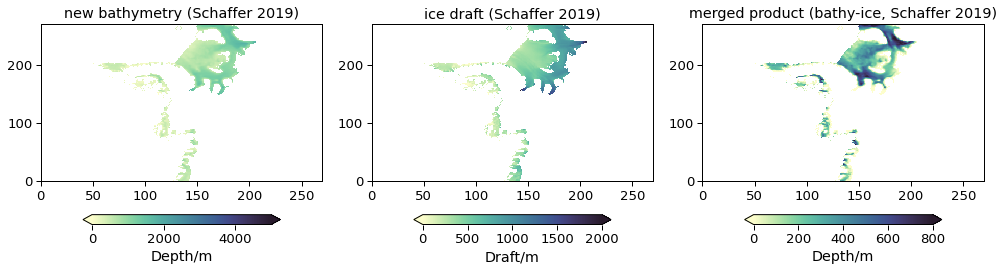

In [104]:
fig = plt.figure(figsize=(14,4), layout='tight')

ax2 = fig.add_subplot(1,3,1)
c=ax2.pcolormesh((bathy*cav_mask).isel(face=12), cmap=cmo.deep, vmax=5000, vmin=0)
cb = fig.colorbar(c, ax=ax2, extend='both', label='Depth/m', orientation='horizontal', shrink=.7)
ax2.set_title('new bathymetry (Schaffer 2019)')

ax3 = fig.add_subplot(1,3,2)
c=ax3.pcolormesh((ice*cav_mask).isel(face=12), cmap=cmo.deep, vmax=2000, vmin=0)
cb = fig.colorbar(c, ax=ax3, extend='both', label='Draft/m', orientation='horizontal', shrink=.7)
ax3.set_title('ice draft (Schaffer 2019)')

ax4 = fig.add_subplot(1,3,3)
c=ax4.pcolormesh((-bathy_merged*cav_mask).isel(face=12), cmap=cmo.deep, vmax=800, vmin=0)
cb = fig.colorbar(c, ax=ax4, extend='both', label='Depth/m', orientation='horizontal', shrink=.7)
ax4.set_title('merged product (bathy-ice, Schaffer 2019)');

if makeplots:
    plt.savefig('plots/bathy_Schaffer2019_AAP_cavity.jpg', bbox_inches='tight', dpi=300)